In [1]:
# %load D:/BUDS_MID/__init__.py
"""
Created on Wed Feb 19 16:21:00 2020

@author: cmchico

usual imports
"""

import os
import pandas as pd
import numpy as np

pd.options.display.max_rows = 100
pd.set_option('display.float_format', '{:.0f}'.format)

from time import time
from datetime import timedelta

import matplotlib.pyplot as plt

import pickle

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# %load D:/BUDS_MID/__initdask__.py
"""
Created on Wed Feb 19 16:24:03 2020

@author: cmchico
"""
import dask.bag as db
from dask.distributed import Client, progress

client = Client(processes = True,n_workers=12)
client

'\nCreated on Wed Feb 19 16:24:03 2020\n\n@author: cmchico\n'

C:\ProgramData\Anaconda3\lib\site-packages\distributed\bokeh\core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: tcp://127.0.0.1:63238 Dashboard: http://127.0.0.1:63241/status,Cluster Workers: 12 Cores: 12 Memory: 34.14 GB


In [3]:
path = "D:/BUDS OUT/ATM TSR/"
files = [file for file in os.listdir(path) if '.pkl' in file]

In [3]:
files

['ATMTSR_2017_WDL.pkl',
 'ATMTSR_2018_WDL.pkl',
 'ATMTSR_2019_2020_WDL.pkl',
 'ATMTSR_2019_WDL.pkl']

In [4]:
df = pd.concat([pd.read_pickle("D:/BUDS OUT/ATM TSR/" + i).assign(file=i) for i in files], sort=False,ignore_index=True)

In [5]:
df.TID = df.TID.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2783964 entries, 0 to 2783963
Data columns (total 9 columns):
 #   Column           Dtype         
---  ------           -----         
 0   TID              int32         
 1   WDL_AMT_OFFUS    float64       
 2   WDL_AMT_ONUS     float64       
 3   WDL_COUNT_OFFUS  float64       
 4   WDL_COUNT_ONUS   float64       
 5   WDL_AMT          float64       
 6   WDL_COUNT        float64       
 7   DATE             datetime64[ns]
 8   file             object        
dtypes: datetime64[ns](1), float64(6), int32(1), object(1)
memory usage: 180.5+ MB


In [6]:
# for 2019 where available, choose generated else choose computed by COG

In [7]:
df.groupby(['TID','DATE']).file.nunique().reset_index()

,TID,DATE,file
0,91010003,2017-01-01,1
1,91010003,2017-01-02,1
2,91010003,2017-01-03,1
3,91010003,2017-01-04,1
4,91010003,2017-01-05,1
...,...,...,...
2528015,91019999,2020-02-12,1
2528016,91019999,2020-02-13,1
2528017,91019999,2020-02-14,1
2528018,91019999,2020-02-15,1


In [8]:
df[df.file == 'ATMTSR_2019_2020_WDL.pkl'].DATE.dt.year.nunique()

2

In [9]:
df[df.DATE.dt.year==2019].DATE.dt.month.value_counts()

1     139182
3     139126
4     132371
2     125232
7      73649
8      72295
5      71998
10     71293
6      70375
9      69503
12     69368
11     68356
Name: DATE, dtype: int64

In [10]:
df2 = df.drop_duplicates(subset=['TID','DATE'], keep='first').copy()

In [11]:
df2.info()
df2.file.value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2528020 entries, 0 to 2528019
Data columns (total 9 columns):
 #   Column           Dtype         
---  ------           -----         
 0   TID              int32         
 1   WDL_AMT_OFFUS    float64       
 2   WDL_AMT_ONUS     float64       
 3   WDL_COUNT_OFFUS  float64       
 4   WDL_COUNT_ONUS   float64       
 5   WDL_AMT          float64       
 6   WDL_COUNT        float64       
 7   DATE             datetime64[ns]
 8   file             object        
dtypes: datetime64[ns](1), float64(6), int32(1), object(1)
memory usage: 183.2+ MB


ATMTSR_2019_2020_WDL.pkl    951010
ATMTSR_2018_WDL.pkl         794963
ATMTSR_2017_WDL.pkl         782047
Name: file, dtype: int64

In [12]:
df2.DATE.max()

Timestamp('2020-02-16 00:00:00')

In [13]:
master_date = pd.date_range(start='1/1/2017',end='2/16/2020')
master_tid = df2.TID.unique()
master = pd.concat(pd.DataFrame([[i,j] for i in master_date], columns=['DATE','TID']) for j in master_tid)

In [14]:
master.groupby('TID').DATE.count().value_counts()

1142    2759
Name: DATE, dtype: int64

In [15]:
master = master.merge(df2, how='left', on=['DATE','TID'] )

In [16]:
master.groupby('TID').DATE.count().value_counts()

1142    2759
Name: DATE, dtype: int64

### Check for Null

In [17]:
master.WDL_AMT.isnull().groupby(master.TID).sum()
# groupby('TID').WDL_AMT.

TID
91010003    24
91010004    83
91010005    11
91010008   113
91010009    15
            ..
91019995    40
91019996    42
91019997   929
91019998   294
91019999    84
Name: WDL_AMT, Length: 2759, dtype: float64

In [18]:
master[master.TID==91019997].file.value_counts()

ATMTSR_2017_WDL.pkl    213
Name: file, dtype: int64

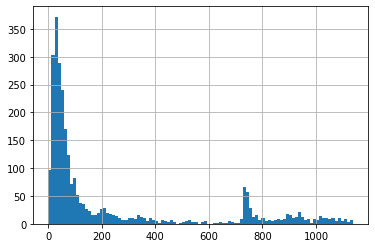

In [19]:
master.WDL_AMT.isnull().groupby(master.TID).sum().hist(bins=100)

In [20]:
(master.WDL_AMT == 0).sum()/master.shape[0]
# .groupby(['TID','DATE'])
(master.WDL_AMT.isnull()).sum()/master.shape[0]

0.00422594038678701

0.19765816569748804

In [21]:
(master.WDL_AMT>0).sum()/master.shape[0]
(master.WDL_AMT>100).sum()/master.shape[0]
(master.WDL_AMT>1000).sum()/master.shape[0]

0.7981124027145041

0.7981114505687167

0.7972418240828139

In [22]:
(master.WDL_AMT>1000).groupby(by=[master.TID, master.DATE.dt.year]).sum()

TID       DATE
91010003  2017   350
          2018   357
          2019   363
          2020    47
91010004  2017   330
                  ..
91019998  2020     0
91019999  2017   328
          2018   322
          2019   351
          2020    44
Name: WDL_AMT, Length: 11036, dtype: float64

In [52]:
master.to_pickle("D:/BUDS OUT/ATM TSR/81 ATMTSR_2017_2020.pkl")

##### filter 1: based on availability week should at least be 90% for 2017-2019

In [385]:
def count_amt(x):
    return sum(x>100)

In [386]:
avail  = master[master.DATE.dt.year < 2020].pivot_table(index=[master.TID,master.DATE.dt.to_period('Y')], 
                   columns=[master.DATE.dt.day_name()],
                   values='WDL_AMT',
                  aggfunc=[count_amt]).reset_index()

In [387]:
avail

TID  DATE count_amt                                          \
DATE                    Friday Monday Saturday Sunday Thursday Tuesday   
0     91010003  2017        51     51       50     50       49      50   
1     91010003  2018        51     53       50     50       50      52   
2     91010003  2019        52     52       51     52       52      53   
3     91010004  2017        49     45       47     47       48      47   
4     91010004  2018        50     50       50     50       50      51   
...        ...   ...       ...    ...      ...    ...      ...     ...   
8272  91019998  2018        47     48       47     48       45      51   
8273  91019998  2019        24     26       26     27       27      27   
8274  91019999  2017        46     46       48     46       49      49   
8275  91019999  2018        47     48       46     44       47      45   
8276  91019999  2019        50     48       50     50       52      51   

                
DATE Wednesday  
0           49  
1           51  
2           51  
3           47  
4           51  
...        ...  
8272        50  
8273        27  
8274        47  
8275        48  
8276        50  

[8277 rows x 9 columns]

In [388]:
avail['week_max'] = avail['count_amt'].max(axis=1)
avail['week_min'] = avail['count_amt'].min(axis=1)
avail['week_avail'] = avail['week_max'] / 52.0

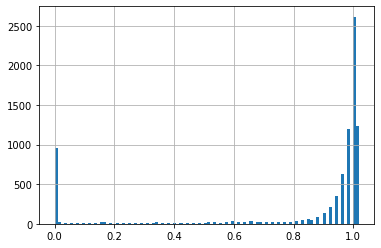

In [389]:
avail.week_avail.hist(bins=100)

In [390]:
avail.columns=avail.columns.map(''.join)

select = (avail.week_avail >= 0.95).groupby(avail.TID).sum() == 3
select.sum() / select.shape[0]

select = (avail.week_avail >= 0.90).groupby(avail.TID).sum() == 3
select.sum() / select.shape[0]

0.46139905762957595

0.6187024284160928

In [391]:
select = select.map({True:'',False:'LT90% available week'}).reset_index()
select.columns = ['TID','filter_']

In [392]:
select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2759 entries, 0 to 2758
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   TID      2759 non-null   int64 
 1   filter_  2759 non-null   object
dtypes: int64(1), object(1)
memory usage: 43.2+ KB


In [393]:
avail = avail.merge(select)
avail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8277 entries, 0 to 8276
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype        
---  ------              --------------  -----        
 0   TID                 8277 non-null   int64        
 1   DATE                8277 non-null   period[A-DEC]
 2   count_amtFriday     8277 non-null   float64      
 3   count_amtMonday     8277 non-null   float64      
 4   count_amtSaturday   8277 non-null   float64      
 5   count_amtSunday     8277 non-null   float64      
 6   count_amtThursday   8277 non-null   float64      
 7   count_amtTuesday    8277 non-null   float64      
 8   count_amtWednesday  8277 non-null   float64      
 9   week_max            8277 non-null   float64      
 10  week_min            8277 non-null   float64      
 11  week_avail          8277 non-null   float64      
 12  filter_             8277 non-null   object       
dtypes: float64(10), int64(1), object(1), period[A-DEC](1)
memory us

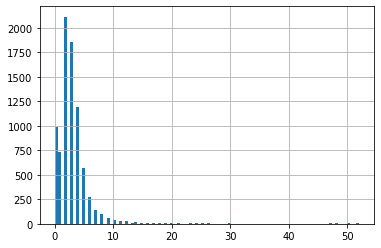

In [395]:
(avail.week_max - avail.week_min).hist(bins=100)

In [396]:
select = avail[['TID'] + [col for col in avail.columns if 'count' in col]].groupby('TID').std().max(axis=1).reset_index()
select.columns = ['TID', 'std_']

In [397]:
avail = avail.merge(select)

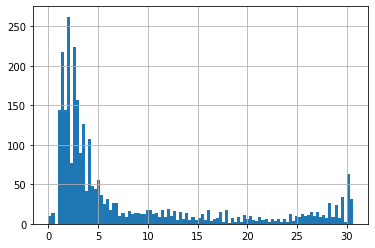

In [398]:
select.std_.hist(bins=100)

In [399]:
#until 5 is acceptable, if std >=6, means at least 1 day within the week changed in availability from 
#52 weeks to ~40 weeks within the 3yrs
avail[(avail.std_==5) & (avail.filter_ == "")].head(100)

,TID,DATE,count_amtFriday,count_amtMonday,count_amtSaturday,count_amtSunday,count_amtThursday,count_amtTuesday,count_amtWednesday,week_max,week_min,week_avail,filter_,std_
2898,91016724,2017,51,51,51,51,50,52,51,52,50,1,,5
2899,91016724,2018,51,48,50,41,50,49,49,51,41,1,,5
2900,91016724,2019,52,52,52,46,52,51,52,52,46,1,,5
6420,91018898,2017,46,47,47,46,47,47,46,47,46,1,,5
6421,91018898,2018,49,51,49,51,46,50,51,51,46,1,,5
6422,91018898,2019,52,47,45,41,52,52,50,52,41,1,,5


In [402]:
select = (avail.std_>5) & (avail.filter_ == "")
avail.loc[select,'filter_'] = 'Changed availability week'

In [403]:
avail.drop_duplicates(subset='TID').filter_.value_counts()

                             1612
LT90% available week         1052
Changed availability week      95
Name: filter_, dtype: int64

##### filter 2: based on demand, should not have drastically changed over the years

##### nothing conclusive

In [404]:
avail_d = master.groupby(['TID', master.DATE.dt.to_period('Y')]).WDL_AMT.agg(['mean']).reset_index()
avail_d.columns=['TID','DATE','amt_mean']

In [405]:
avail_d2 = avail_d \
    .groupby(['TID'])['amt_mean'].agg(['mean','std']).reset_index()

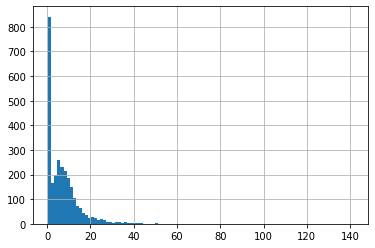

In [406]:
(avail_d2['mean'] / avail_d2['std']).hist(bins=100)

In [407]:
avail_d2['mean_std'] = avail_d2['mean'] / avail_d2['std']

In [408]:
avail_d2.columns= ['TID','amt_mean_y','amt_std_y','amt_mean_std_y']

In [409]:
avail = avail.merge(avail_d).merge(avail_d2)

In [410]:
avail[avail.amt_mean_std_y<6]

,TID,DATE,count_amtFriday,count_amtMonday,count_amtSaturday,count_amtSunday,count_amtThursday,count_amtTuesday,count_amtWednesday,week_max,week_min,week_avail,filter_,std_,amt_mean,amt_mean_y,amt_std_y,amt_mean_std_y
0,91010003,2017,51,51,50,50,49,50,49,51,49,1,,2,438815,584278,103232,6
1,91010003,2018,51,53,50,50,50,52,51,53,50,1,,2,584574,584278,103232,6
2,91010003,2019,52,52,51,52,52,53,51,53,51,1,,2,668571,584278,103232,6
9,91010008,2017,50,49,49,49,50,49,50,50,49,1,,4,562498,469077,319103,1
10,91010008,2018,52,53,52,51,51,50,52,53,50,1,,4,712408,469077,319103,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8269,91019997,2018,0,0,0,0,0,0,0,0,0,0,LT90% available week,18,0,72161,144323,0
8270,91019997,2019,0,0,0,0,0,0,0,0,0,0,LT90% available week,18,0,72161,144323,0
8271,91019998,2017,47,45,47,47,49,47,46,49,45,1,LT90% available week,13,831181,412193,349838,1
8272,91019998,2018,47,48,47,48,45,51,50,51,45,1,LT90% available week,13,512921,412193,349838,1


In [411]:
avail = avail.merge(avail_d)

In [412]:
avail.to_pickle('81 Availability Info.pkl')

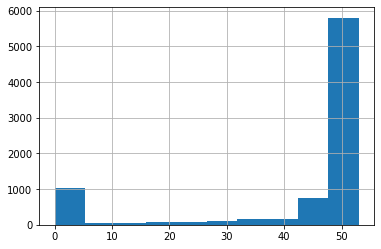

In [421]:
avail.count_amtTuesday.hist(bins=10)

In [426]:
avail.groupby(['TID']).mean().head(100)

,count_amtFriday,count_amtMonday,count_amtSaturday,count_amtSunday,count_amtThursday,count_amtTuesday,count_amtWednesday,week_max,week_min,week_avail,std_,amt_mean,amt_mean_y,amt_std_y,amt_mean_std_y
TID,,,,,,,,,,,,,,,
91010003,51,52,50,51,50,52,50,52,50,1,2,563987,584278,103232,6
91010004,49,47,48,48,49,48,49,49,47,1,3,1170050,1234600,164629,7
91010005,52,51,51,51,51,52,52,53,50,1,2,1759448,1798947,117416,15
91010008,49,49,49,49,49,49,49,50,48,1,4,625436,469077,319103,1
91010009,52,51,51,50,51,52,52,52,50,1,1,1174174,1186842,116140,10
91010010,50,50,50,50,50,51,51,52,48,1,2,639357,646324,26130,25
91010012,49,51,50,50,50,51,51,52,48,1,3,854147,865464,59352,15
91010016,51,51,50,49,50,51,51,52,49,1,2,1125947,1148721,106482,11
91010017,51,52,50,50,51,51,52,52,49,1,3,655367,743567,188431,4


In [425]:
avail.tail(20)

,TID,DATE,count_amtFriday,count_amtMonday,count_amtSaturday,count_amtSunday,count_amtThursday,count_amtTuesday,count_amtWednesday,week_max,week_min,week_avail,filter_,std_,amt_mean,amt_mean_y,amt_std_y,amt_mean_std_y
8257,91019992,2018,51,53,52,51,51,52,52,53,51,1,,2,1133523,1089267,99796,11
8258,91019992,2019,51,51,51,48,50,53,50,53,48,1,,2,1140701,1089267,99796,11
8259,91019993,2017,51,51,50,51,51,51,51,51,50,1,,2,324400,377875,36541,10
8260,91019993,2018,48,49,48,48,49,47,50,50,47,1,,2,402460,377875,36541,10
8261,91019993,2019,48,48,49,47,47,48,48,49,47,1,,2,384435,377875,36541,10
8262,91019995,2017,49,50,48,50,51,52,52,52,48,1,,2,924217,999060,104876,10
8263,91019995,2018,49,50,51,49,50,51,51,51,49,1,,2,927410,999060,104876,10
8264,91019995,2019,49,51,48,46,50,52,49,52,46,1,,2,996376,999060,104876,10
8265,91019996,2017,49,49,49,50,52,51,52,52,49,1,,2,794798,853680,64554,13
8266,91019996,2018,49,50,49,49,48,51,50,51,48,1,,2,808092,853680,64554,13


In [53]:
# master = master.fillna(0).merge(avail[['TID','filter_']].drop_duplicates(),how='left')

In [54]:
# master.loc[master.filter_.isnull(),'filter_'] = 'Only 2020'

In [413]:
# master[['TID','filter_']].drop_duplicates().filter_.value_counts()

In [414]:
avail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8277 entries, 0 to 8276
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype        
---  ------              --------------  -----        
 0   TID                 8277 non-null   int64        
 1   DATE                8277 non-null   period[A-DEC]
 2   count_amtFriday     8277 non-null   float64      
 3   count_amtMonday     8277 non-null   float64      
 4   count_amtSaturday   8277 non-null   float64      
 5   count_amtSunday     8277 non-null   float64      
 6   count_amtThursday   8277 non-null   float64      
 7   count_amtTuesday    8277 non-null   float64      
 8   count_amtWednesday  8277 non-null   float64      
 9   week_max            8277 non-null   float64      
 10  week_min            8277 non-null   float64      
 11  week_avail          8277 non-null   float64      
 12  filter_             8277 non-null   object       
 13  std_                8277 non-null   float64      
 14  amt_mean

In [415]:
# master.info()

In [58]:
avail[['TID','filter_']].drop_duplicates().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2759 entries, 0 to 8274
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   TID      2759 non-null   int64 
 1   filter_  2759 non-null   object
dtypes: int64(1), object(1)
memory usage: 64.7+ KB


In [183]:
# master = pd.read_pickle('81 W Data Filter Labels.pkl')

##### based on tickets, not a lot

In [184]:
ticket = pd.read_pickle('D:/BUDS OUT/ATM Ticket/80 Ticket_All_Per_Day_Dur.pkl')
ticket['DATE'] = pd.to_datetime(ticket.t_start)
ticket['TID'] = ticket.tid
ticket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801843 entries, 0 to 801842
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   tid            801843 non-null  int64         
 1   t_start        801843 non-null  object        
 2   t_duration_hr  801843 non-null  int32         
 3   DATE           801843 non-null  datetime64[ns]
 4   TID            801843 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(2), object(1)
memory usage: 27.5+ MB


In [185]:
master = master.merge(ticket[['TID','DATE','t_duration_hr']], on=['TID','DATE'], how='left')

In [186]:
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3150778 entries, 0 to 3150777
Data columns (total 11 columns):
 #   Column           Dtype         
---  ------           -----         
 0   DATE             datetime64[ns]
 1   TID              int64         
 2   WDL_AMT_OFFUS    float64       
 3   WDL_AMT_ONUS     float64       
 4   WDL_COUNT_OFFUS  float64       
 5   WDL_COUNT_ONUS   float64       
 6   WDL_AMT          float64       
 7   WDL_COUNT        float64       
 8   file             object        
 9   filter_          object        
 10  t_duration_hr    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(2)
memory usage: 288.5+ MB


In [187]:
master.groupby('t_duration_hr').WDL_AMT.mean()

t_duration_hr
0    1035117
1    1023766
2    1042774
3    1047979
4    1048757
5    1030147
6    1007864
7     972377
8     979190
9     932937
10    951062
11    922176
12    826905
13    892822
14    865000
15    861828
16    846154
17    847850
18    829362
19    809349
20    821252
21    861757
22    881748
23    902171
24    666925
Name: WDL_AMT, dtype: float64

In [188]:
select = (master.WDL_AMT > 0) & (master.DATE.dt.year < 2020)
master.loc[select,'WDL_AMT_STD_YR'] = master[select].groupby(['TID', master.DATE.dt.year]).WDL_AMT.transform(lambda x: (x - x.mean()) / x.std())

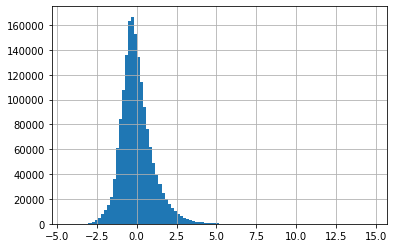

In [189]:
master[master.filter_ == ""].WDL_AMT_STD_YR.hist(bins=100)

In [190]:
master[master.WDL_AMT_STD_YR > 5]

,DATE,TID,WDL_AMT_OFFUS,WDL_AMT_ONUS,WDL_COUNT_OFFUS,WDL_COUNT_ONUS,WDL_AMT,WDL_COUNT,file,filter_,t_duration_hr,WDL_AMT_STD_YR
1474,2017-11-29,91010004,1219400,2664300,191,494,3883700,685,ATMTSR_2017_WDL.pkl,,nan,5
3836,2018-02-15,91010016,362400,3976500,48,555,4338900,603,ATMTSR_2018_WDL.pkl,,1,5
13975,2017-09-29,91010037,202000,2912500,26,454,3114500,480,ATMTSR_2017_WDL.pkl,,nan,7
23188,2017-12-15,91010051,985000,1757400,130,225,2742400,355,ATMTSR_2017_WDL.pkl,,nan,5
25836,2018-12-14,91010055,864800,2739200,103,289,3604000,392,ATMTSR_2018_WDL.pkl,,nan,5
...,...,...,...,...,...,...,...,...,...,...,...,...
3068424,2019-10-10,91015380,500,2774900,1,445,2775400,446,ATMTSR_2019_2020_WDL.pkl,LT90% available week,3,5
3069630,2019-12-13,91015467,333100,2691600,53,325,3024700,378,ATMTSR_2019_2020_WDL.pkl,LT90% available week,nan,5
3090196,2019-12-23,91015477,716000,1965000,91,242,2681000,333,ATMTSR_2019_2020_WDL.pkl,LT90% available week,nan,6
3106192,2019-12-31,91015320,20000,717400,2,147,737400,149,ATMTSR_2019_2020_WDL.pkl,LT90% available week,nan,5


DATE
2017    AxesSubplot(0.125,0.125;0.775x0.755)
2018    AxesSubplot(0.125,0.125;0.775x0.755)
2019    AxesSubplot(0.125,0.125;0.775x0.755)
2020    AxesSubplot(0.125,0.125;0.775x0.755)
Name: WDL_AMT, dtype: object

No handles with labels found to put in legend.


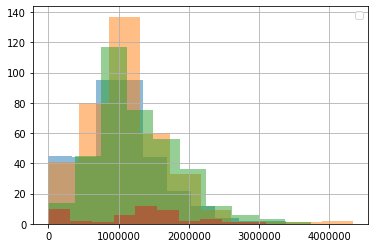

In [191]:
master[master.TID==91010016].groupby(master[master.TID==91010016].DATE.dt.year).WDL_AMT.hist(alpha=0.5)
plt.legend()

DATE
2017    AxesSubplot(0.125,0.125;0.775x0.755)
2018    AxesSubplot(0.125,0.125;0.775x0.755)
2019    AxesSubplot(0.125,0.125;0.775x0.755)
2020    AxesSubplot(0.125,0.125;0.775x0.755)
Name: WDL_AMT_STD_YR, dtype: object

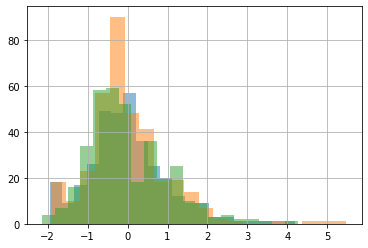

In [192]:
master[master.TID==91010016].groupby(master[master.TID==91010016].DATE.dt.year).WDL_AMT_STD_YR.hist(alpha=0.5, bins=20)

In [196]:
sum(master.WDL_AMT.isnull())

0

##### Imputation

In [315]:
import random

In [316]:
master['DAY'] = master.DATE.dt.day_name()

In [317]:
def impute_wdl_amt(df):
    df = df.copy()
    for year in [2017,2018,2019]:
        for day in ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']:
            print(year,day)
            select = (df.DAY==day) & (df.DATE.dt.year==year) & (df.TID == df.TID.unique()[0])
            dist = df[(select) & (df.WDL_AMT > 0)].WDL_AMT.values
            if dist.shape[0] == 0:
                df.loc[select,'WDL_AMT_IMPUTE'] = 0
            else:
                samples = pd.Series(random.choices(dist, k = 10000))
#                 df.loc[select,'WDL_AMT_IMPUTE'] = [samples.quantile(random.random()) for i in range(sum(select))]
                df.loc[select,'WDL_AMT_IMPUTE'] = [samples.quantile(q=0.05 + random.random()*0.85) for i in range(sum(select))]
    return df



0:07:46.731589


In [322]:
def impute_wdl_amt_offus(df):
    df = df.copy()
    for year in [2017,2018,2019]:
        for day in ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']:
            print(year,day)
            select = (df.DAY==day) & (df.DATE.dt.year==year) & (df.TID == df.TID.unique()[0])
            dist = df[(select) & (df.WDL_AMT_OFFUS > 0)].WDL_AMT_OFFUS.values
            if dist.shape[0] == 0:
                df.loc[select,'WDL_AMT_OFFUS_IMPUTE'] = 0
            else:
                samples = pd.Series(random.choices(dist, k = 10000))
#                 df.loc[select,'WDL_AMT_IMPUTE'] = [samples.quantile(random.random()) for i in range(sum(select))]
                df.loc[select,'WDL_AMT_OFFUS_IMPUTE'] = [samples.quantile(q=0.05 + random.random()*0.85) for i in range(sum(select))]
    return df

In [323]:
master['WDL_AMT_OFFUS_IMPUTE'] = 0
start=time()
dbdf = db.from_sequence([master[master.TID==i] for i in master.TID.unique()])
dbmaster = dbdf.map(impute_wdl_amt_offus)
df = dbmaster.compute()
fin = pd.concat([df[i] for i in range(master.TID.nunique())], ignore_index=True)
print(timedelta(seconds=time()-start))

0:07:31.909215


In [332]:
fin

,DATE,TID,WDL_AMT_OFFUS,WDL_AMT_ONUS,WDL_COUNT_OFFUS,WDL_COUNT_ONUS,WDL_AMT,WDL_COUNT,file,filter_,t_duration_hr,WDL_AMT_STD_YR,DAY,WDL_AMT_IMPUTE,WDL_AMT_OFFUS_IMPUTE
0,2017-01-01,91010003,12700,23600,5,10,36300,15,ATMTSR_2017_WDL.pkl,,nan,-2,Sunday,0,69400
1,2017-01-02,91010003,68100,132900,21,35,201000,56,ATMTSR_2017_WDL.pkl,,nan,-1,Monday,0,79700
2,2017-01-03,91010003,115100,342600,32,84,457700,116,ATMTSR_2017_WDL.pkl,,nan,0,Tuesday,0,115100
3,2017-01-04,91010003,133800,386700,36,92,520500,128,ATMTSR_2017_WDL.pkl,,nan,0,Wednesday,0,116200
4,2017-01-05,91010003,160800,446400,24,100,607200,124,ATMTSR_2017_WDL.pkl,,nan,1,Thursday,0,147300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3150773,2020-02-12,91015693,0,0,0,0,0,0,ATMTSR_2019_2020_WDL.pkl,LT90% available week,nan,nan,Wednesday,0,0
3150774,2020-02-13,91015693,0,59000,0,12,59000,12,ATMTSR_2019_2020_WDL.pkl,LT90% available week,nan,nan,Thursday,0,0
3150775,2020-02-14,91015693,0,107900,0,27,107900,27,ATMTSR_2019_2020_WDL.pkl,LT90% available week,nan,nan,Friday,0,0
3150776,2020-02-15,91015693,0,80800,0,21,80800,21,ATMTSR_2019_2020_WDL.pkl,LT90% available week,nan,nan,Saturday,0,0


In [333]:
fin['WDL_AMT_IMPUTE'] = 0
start=time()
dbdf = db.from_sequence([fin[fin.TID==i] for i in fin.TID.unique()])
dbmaster = dbdf.map(impute_wdl_amt)
df = dbmaster.compute()
fin2 = pd.concat([df[i] for i in range(fin.TID.nunique())], ignore_index=True)
print(timedelta(seconds=time()-start))

0:07:23.118667


In [ ]:
# df = impute_wdl_amt(master[master.TID==91010136])
# df[(df.DAY == 'Monday') & (df.DATE.dt.year < 2020)].groupby(df[df.DAY == 'Monday'].DATE.dt.year).WDL_AMT.hist(alpha=0.5)
# plt.show()
# df[(df.DAY == 'Monday') & (df.DATE.dt.year < 2020)].groupby(df[df.DAY == 'Monday'].DATE.dt.year).WDL_AMT_IMPUTE.hist(alpha=0.5)
# plt.show()

In [369]:
# fin2['YEAR'] = fin2.DATE.dt.year

In [469]:
# fin2['WDL_AMT_STD_DAY_YR'] = -99
# select = (fin2.YEAR < 2020)
# fin2.loc[select,'WDL_AMT_STD_DAY_YR'] = fin2[select].groupby(['TID', 'YEAR','DAY']).WDL_AMT.transform(lambda x: (x - x.mean()) / x.std())

KeyboardInterrupt: 

In [ ]:
# fin2['WDL_AMT_OFFUS_STD_DAY_YR'] = -99
# select = (fin2.YEAR < 2020)
# fin2.loc[select,'WDL_AMT_OFFUS_STD_DAY_YR'] = fin2[select].groupby(['TID', 'YEAR','DAY']).WDL_AMT_OFFUS.transform(lambda x: (x - x.mean()) / x.std())

In [344]:
fin2.head()

,DATE,TID,WDL_AMT_OFFUS,WDL_AMT_ONUS,WDL_COUNT_OFFUS,WDL_COUNT_ONUS,WDL_AMT,WDL_COUNT,file,filter_,t_duration_hr,WDL_AMT_STD_YR,DAY,WDL_AMT_IMPUTE,WDL_AMT_OFFUS_IMPUTE,WDL_AMT_STD_DAY_YR,WDL_AMT_OFFUS_STD_DAY_YR
0,2017-01-01,91010003,12700,23600,5,10,36300,15,ATMTSR_2017_WDL.pkl,,nan,-2,Sunday,215100,69400,-2,-1
1,2017-01-02,91010003,68100,132900,21,35,201000,56,ATMTSR_2017_WDL.pkl,,nan,-1,Monday,489300,79700,-2,-0
2,2017-01-03,91010003,115100,342600,32,84,457700,116,ATMTSR_2017_WDL.pkl,,nan,0,Tuesday,457700,115100,-0,0
3,2017-01-04,91010003,133800,386700,36,92,520500,128,ATMTSR_2017_WDL.pkl,,nan,0,Wednesday,466900,116200,0,1
4,2017-01-05,91010003,160800,446400,24,100,607200,124,ATMTSR_2017_WDL.pkl,,nan,1,Thursday,624200,147300,1,0


### get G4S

In [334]:
g2s = pd.read_excel('D:/BUDS/ATM Daily Withdrawals/Manage Group 2019.xlsx')

In [335]:
g2s = g2s[g2s.Type=='ATM'].pivot_table(index='  TID   ', columns='Manage Group',aggfunc='count')
g2s.columns = g2s.columns.levels[1]

In [336]:
# (g2s.G4S.isnull())
select = g2s.sum(axis=1) - g2s.G4S == 0
g2s_list = g2s[select].index.values

In [345]:
fin2['G4S_2019'] = 'NO'

In [346]:
select = fin2.TID.isin(g2s_list)

In [347]:
fin2.loc[select,'G4S_2019'] = 'YES'

In [358]:
fin2[['TID','filter_','G4S_2019']].drop_duplicates().groupby(['G4S_2019','filter_']).size().reset_index()

,G4S_2019,filter_,0
0,NO,,707
1,NO,Changed availability week,32
2,NO,LT90% available week,534
3,YES,,905
4,YES,Changed availability week,63
5,YES,LT90% available week,518


In [351]:
fin2.to_pickle('81 W Data Filter Impute G4S.pkl')

In [352]:
fin2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150778 entries, 0 to 3150777
Data columns (total 18 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   DATE                      datetime64[ns]
 1   TID                       int64         
 2   WDL_AMT_OFFUS             float64       
 3   WDL_AMT_ONUS              float64       
 4   WDL_COUNT_OFFUS           float64       
 5   WDL_COUNT_ONUS            float64       
 6   WDL_AMT                   float64       
 7   WDL_COUNT                 float64       
 8   file                      object        
 9   filter_                   object        
 10  t_duration_hr             float64       
 11  WDL_AMT_STD_YR            float64       
 12  DAY                       object        
 13  WDL_AMT_IMPUTE            float64       
 14  WDL_AMT_OFFUS_IMPUTE      float64       
 15  WDL_AMT_STD_DAY_YR        float64       
 16  WDL_AMT_OFFUS_STD_DAY_YR  float64       
 17  G4S_2019

In [353]:
905+707

1612

In [354]:
fin2.TID.nunique()

2759

In [357]:
fin2.G4S_2019.isnull().sum()

0

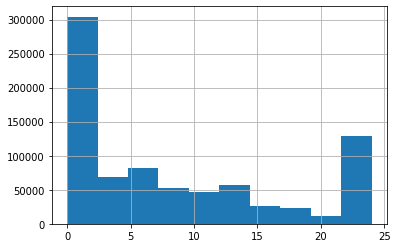

In [361]:
fin2.t_duration_hr.hist()

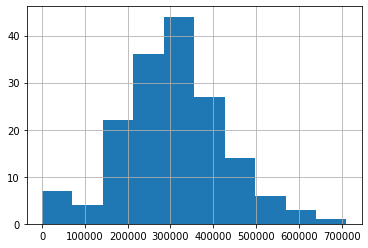

In [364]:
fin2[(fin2.TID==91010003) & (fin2.DAY=='Sunday')].WDL_AMT.hist()

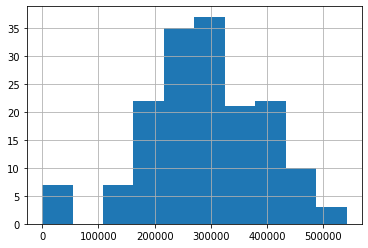

In [365]:
fin2[(fin2.TID==91010003) & (fin2.DAY=='Sunday')].WDL_AMT_IMPUTE.hist()

In [366]:
fin2

,DATE,TID,WDL_AMT_OFFUS,WDL_AMT_ONUS,WDL_COUNT_OFFUS,WDL_COUNT_ONUS,WDL_AMT,WDL_COUNT,file,filter_,t_duration_hr,WDL_AMT_STD_YR,DAY,WDL_AMT_IMPUTE,WDL_AMT_OFFUS_IMPUTE,WDL_AMT_STD_DAY_YR,WDL_AMT_OFFUS_STD_DAY_YR,G4S_2019
0,2017-01-01,91010003,12700,23600,5,10,36300,15,ATMTSR_2017_WDL.pkl,,nan,-2,Sunday,215100,69400,-2,-1,NO
1,2017-01-02,91010003,68100,132900,21,35,201000,56,ATMTSR_2017_WDL.pkl,,nan,-1,Monday,489300,79700,-2,-0,NO
2,2017-01-03,91010003,115100,342600,32,84,457700,116,ATMTSR_2017_WDL.pkl,,nan,0,Tuesday,457700,115100,-0,0,NO
3,2017-01-04,91010003,133800,386700,36,92,520500,128,ATMTSR_2017_WDL.pkl,,nan,0,Wednesday,466900,116200,0,1,NO
4,2017-01-05,91010003,160800,446400,24,100,607200,124,ATMTSR_2017_WDL.pkl,,nan,1,Thursday,624200,147300,1,0,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3150773,2020-02-12,91015693,0,0,0,0,0,0,ATMTSR_2019_2020_WDL.pkl,LT90% available week,nan,nan,Wednesday,0,0,nan,nan,NO
3150774,2020-02-13,91015693,0,59000,0,12,59000,12,ATMTSR_2019_2020_WDL.pkl,LT90% available week,nan,nan,Thursday,0,0,nan,nan,NO
3150775,2020-02-14,91015693,0,107900,0,27,107900,27,ATMTSR_2019_2020_WDL.pkl,LT90% available week,nan,nan,Friday,0,0,nan,nan,NO
3150776,2020-02-15,91015693,0,80800,0,21,80800,21,ATMTSR_2019_2020_WDL.pkl,LT90% available week,nan,nan,Saturday,0,0,nan,nan,NO


###### Determine which to impute

In [4]:
fin2 = pd.read_pickle('81 W Data Filter Impute G4S.pkl')

In [7]:
fin2['YEAR'] = fin2.DATE.dt.year

In [8]:
start  = time()
fin2['WDL_AMT_STD_DAY_YR'] = -99
select = (fin2.YEAR < 2020)
fin2.loc[select,'WDL_AMT_STD_DAY_YR'] = \
    fin2[select].groupby(['TID', 'YEAR','DAY']).WDL_AMT.transform(lambda x: (x - x.mean()) / x.std())
print(timedelta(seconds=time()-start))

0:02:54.466877


In [10]:
start  = time()
fin2['WDL_AMT_OFFUS_STD_DAY_YR'] = -99
select = (fin2.YEAR < 2020)
fin2.loc[select,'WDL_AMT_OFFUS_STD_DAY_YR'] = \
    fin2[select].groupby(['TID', 'YEAR','DAY']).WDL_AMT_OFFUS.transform(lambda x: (x - x.mean()) / x.std())
print(timedelta(seconds=time()-start))

0:02:56.617820


1449

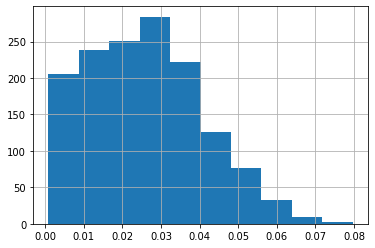

In [34]:
fin2['WDL_AMT_GETIMPUTE'] = ""
select = (fin2.WDL_AMT_STD_DAY_YR < -2) & (fin2.WDL_AMT_STD_DAY_YR > -99) & (fin2.filter_ == "")
fin2.loc[select,'WDL_AMT_GETIMPUTE'] = "YES"

with_impute = fin2[fin2.WDL_AMT_GETIMPUTE=="YES"].groupby(['TID']).size()
with_impute.shape[0]

#less than 10% with -2 std dev away
(with_impute/fin2[fin2.TID.isin(with_impute.index)].groupby(['TID']).size()).hist()

1342

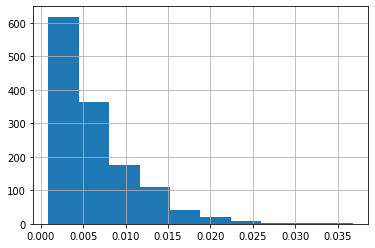

In [42]:
#unavailable half day and amt is 2 stddev away from mean, CHOOSE THIS
#all imputations are <1% of data for those that are retained
fin2['WDL_AMT_GETIMPUTE'] = ""

select = (fin2.WDL_AMT_STD_DAY_YR < -2) & (fin2.WDL_AMT_STD_DAY_YR > -99) & (fin2.filter_ == "") & (fin2.t_duration_hr > 12)
fin2.loc[select,'WDL_AMT_GETIMPUTE'] = "YES"


with_impute = fin2[fin2.WDL_AMT_GETIMPUTE=="YES"].groupby(['TID']).size()
with_impute.shape[0]
#less than 10% with -2 std dev away
(with_impute/fin2[fin2.TID.isin(with_impute.index)].groupby(['TID']).size()).hist()

In [40]:
fin2['WDL_AMT_GETIMPUTE'] = ""
select = (fin2.WDL_AMT_STD_DAY_YR < -2) & (fin2.WDL_AMT_STD_DAY_YR > -99) & (fin2.t_duration_hr > 12)
fin2.loc[select,'WDL_AMT_GETIMPUTE'] = "YES"

fin2['WDL_AMT_FIN'] = fin2['WDL_AMT']
fin2.loc[select,'WDL_AMT_FIN'] = fin2.loc[select,'WDL_AMT_IMPUTE']

In [43]:
fin2.to_pickle('81 W Data Filter Impute G4S.pkl')

In [6]:
fin2=pd.read_pickle('D:/BUDS_MID/OJT ATM/ATM Forecasting Data New/Actual/81 W Data Filter Impute G4S.pkl')

In [20]:
len(fin2.columns)

21

In [13]:
fin2[['DATE', 'TID','WDL_AMT_FIN','WDL_AMT', 'WDL_COUNT']] \
        .to_csv('D:/BUDS_MID/OJT ATM/ATM Forecasting Data New/Actual/81 p1 WDLs.csv', index=False)

In [15]:
fin2[['DATE','TID','WDL_AMT_OFFUS', 'WDL_AMT_ONUS', 'WDL_COUNT_OFFUS',
       'WDL_COUNT_ONUS']] \
        .to_csv('D:/BUDS_MID/OJT ATM/ATM Forecasting Data New/Actual/81 p1 WDLs OFFUS ONUS.csv', index=False)

In [16]:
fin2[['DATE','TID','t_duration_hr']] \
        .to_csv('D:/BUDS_MID/OJT ATM/ATM Forecasting Data New/Actual/81 p2 Ticket.csv', index=False)

In [17]:
fin2[['DATE','TID', 'WDL_AMT_STD_YR','WDL_AMT_STD_DAY_YR','WDL_AMT_OFFUS_STD_DAY_YR']] \
        .to_csv('D:/BUDS_MID/OJT ATM/ATM Forecasting Data New/Actual/81 p3 STD WDLs.csv', index=False)

In [19]:
fin2[[ 'DATE','TID', 'file', 'filter_','G4S_2019','WDL_AMT_GETIMPUTE']] \
        .to_csv('D:/BUDS_MID/OJT ATM/ATM Forecasting Data New/Actual/81 p4 Flags.csv', index=False)